In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import numpy as np
import pandas as pd

In [ ]:
from sklearn.model_selection import train_test_split

In [2]:
a = pd.read_csv('housing.csv')

In [4]:
a.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']
normalize_ones = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categorical_ones = ['ocean_proximity']
target_y = ['median_house_value']

In [6]:
train_df, test_df = train_test_split(a)

In [7]:
train_df.shape, test_df.shape

((15480, 10), (5160, 10))

In [8]:
torch.save([train_df, test_df], 'train_test_dfs_CH_v2.pt')

In [9]:
means = {}
stds = {}
cate_res = {}
for j in features + target_y:
    if j in normalize_ones or j in target_y:
        means[j] = train_df[j].mean()
        stds[j] = train_df[j].std()
    if j in categorical_ones:
        cate_res[j] = train_df[j].value_counts()

In [10]:
train_xs = []
test_xs = []
train_y = []
test_y = []
for j in features:
    if j in normalize_ones:
        train_xs.append((train_df[j] - means[j])/stds[j])
        test_xs.append((test_df[j] - means[j])/stds[j])
    if j in categorical_ones:
        for c in cate_res[j].index:
            train_xs.append((train_df[j] == c).astype(float).rename(f'{j}_{c}'))
            test_xs.append((test_df[j] == c).astype(float).rename(f'{j}_{c}'))

y_col = target_y[0]
train_y = (train_df[y_col] - means[y_col])/stds[y_col]
test_y = (test_df[y_col] - means[y_col])/stds[y_col]


In [11]:
train_xs = pd.concat(train_xs, axis=1).fillna(0)
test_xs = pd.concat(test_xs, axis=1).fillna(0)


In [12]:
torch.save([train_xs, train_y, test_xs, test_y], 'preprocessed_train_test_dfs_CH_v2.pt')

In [13]:
train_xs.shape

(15480, 13)

In [15]:
list(train_df.ocean_proximity.value_counts().index)

['<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']

In [16]:
train_df.ocean_proximity.value_counts()

<1H OCEAN     6800
INLAND        4923
NEAR OCEAN    2016
NEAR BAY      1736
ISLAND           5
Name: ocean_proximity, dtype: int64

In [17]:
test_df.ocean_proximity.value_counts()

<1H OCEAN     2336
INLAND        1628
NEAR OCEAN     642
NEAR BAY       554
Name: ocean_proximity, dtype: int64

In [18]:
train_y.mean(), train_y.std()

(5.4736577028030976e-17, 1.0000000000000084)

In [19]:
class Multiply(nn.Module):
    def __init__(self, factor):
        super(Multiply, self).__init__()
        self.factor = factor

    def forward(self, x):
        return x*self.factor

In [22]:
train_xs = torch.FloatTensor(train_xs.values).to(device)
train_y = torch.FloatTensor(train_y.values).to(device)
test_xs = torch.FloatTensor(test_xs.values).to(device)
test_y = torch.FloatTensor(test_y.values).to(device)


In [23]:
# torch.save([train_xs, train_y, valid_xs, valid_y, test_xs, test_y], 'torch_tensor_train_valid_test_dfs_CH_v2.pt')
# train_xs, train_y, valid_xs, valid_y, test_xs, test_y = torch.load('torch_tensor_train_valid_test_dfs_CH_v2.pt')

In [25]:
from torch.utils.data import DataLoader
dataloader = DataLoader(torch.arange(len(train_xs)), batch_size=512)

In [26]:
def loss(y, yh):
    return torch.square(y-yh).mean()


# def loss(y, b):
#     use_loss = torch.square(y-b).mean()
#     return (use_loss * torch.clamp(torch.exp(use_loss), max=10)).mean()

In [27]:
all_losses_alpha_more2_full = {}
all_losses_alpha_test2_full = {}
all_losses_alpha_valid2_full = {}

device = 'cuda:0'
# device = 'cpu'
m = 5000
for alpha in [-1, 0.05, 0, 0.01, -2.0]:
    z2 = nn.Sequential(nn.Linear(13, m), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, m), 
                      nn.LeakyReLU(alpha), 
                      Multiply(1./np.sqrt(1+alpha**2)), 
                      nn.Linear(m, 1))
    nn.init.constant_(z2[0].bias, 0)
    nn.init.normal_(z2[0].weight, mean=0, std=np.sqrt(1./m))
    nn.init.constant_(z2[1].bias, 0)
    nn.init.normal_(z2[1].weight, mean=0, std=np.sqrt(2./m))
    nn.init.normal_(z2[4].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[4].bias, 0)
    nn.init.normal_(z2[7].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[7].bias, 0)
    nn.init.normal_(z2[10].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[10].bias, 0)
    nn.init.normal_(z2[13].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[13].bias, 0)
    nn.init.normal_(z2[16].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[16].bias, 0)
    nn.init.normal_(z2[19].weight, mean=0, std=np.sqrt(2./m))
    nn.init.constant_(z2[19].bias, 0)
    nn.init.normal_(z2[22].weight, mean=0, std=np.sqrt(1))
    nn.init.constant_(z2[22].bias, 0)
    z2 = z2.to(device)
    all_losses2 = []
    all_losses_test = []
    all_losses_valid = []
    op2 = optim.SGD(lr=1e-5, params=z2.parameters())
    print ("=============", alpha, "===============")
    for i in range(1000):
        for inds in dataloader:
            use_x = train_xs[inds].to(device)
            use_y = train_y[inds].to(device)
            op2.zero_grad()
            yh = z2(use_x).view(-1)
            loss_use = loss(yh, use_y)
            loss_use.backward()
            if i == 0:
                print (loss_use.item())
            op2.step()
        yh = z2(train_xs).view(-1)
        loss_use = loss(yh, train_y)
        all_losses2.append(loss_use.item())

        yh = z2(test_xs).view(-1)
        loss_use = loss(yh, test_y)
        all_losses_test.append(loss_use.item())

        yh = z2(valid_xs).view(-1)
        loss_use = loss(yh, valid_y)
        all_losses_valid.append(loss_use.item())

        if i % 500 == 0:
            print (i, all_losses2[-1], all_losses_test[-1])
        elif i < 2000 and i % 100 == 0:
            print (i, all_losses2[-1], all_losses_test[-1])
    all_losses_alpha_more2_full[alpha] = all_losses2
    all_losses_alpha_test2_full[alpha] = all_losses_test
    all_losses_alpha_valid2_full[alpha] = all_losses_valid
    torch.save([all_losses_alpha_more2_full, all_losses_alpha_test2_full, all_losses_alpha_valid2_full], f'CH_v2_alpha_experiment_v8_full.pt')

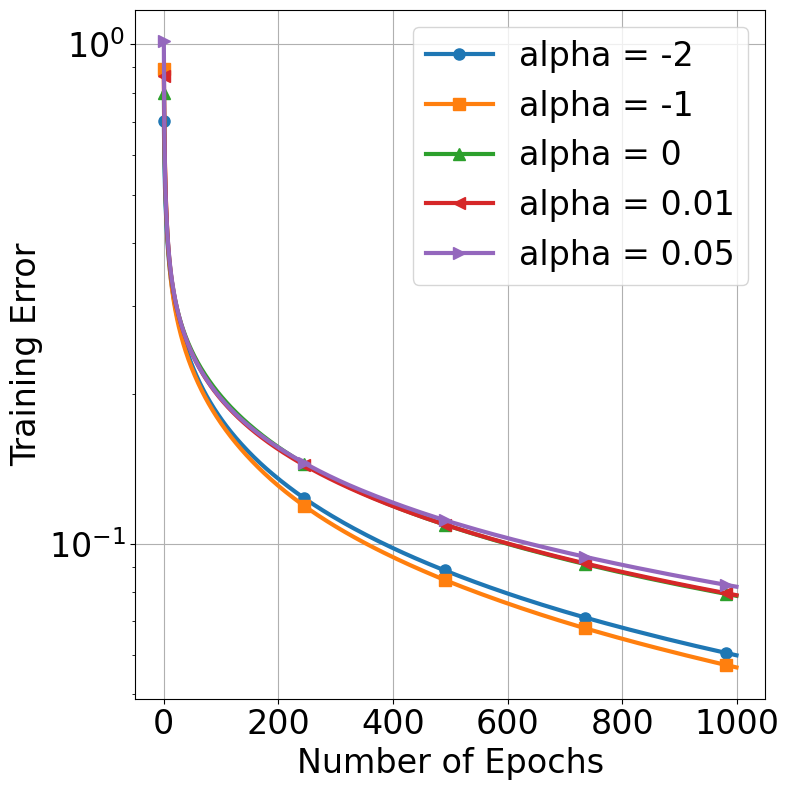

In [32]:
markers = {-2:'o', -1:'s', 0:'^', 0.01:'<', 0.05:'>', -10:'v'}
colors = {-1:'C1',-2:'C0',0:'C2', 0.05:'C4',0.01:'C3'}
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
# check_keys = [j for j in all_losses_alpha_more2.keys()]
j = 0
# markers = ['o', 's', '^', '<', '>', 'v', 'x', 'd', '*']
for key in check_keys:
    ax.plot(all_losses_alpha_more2_full[key][:], linewidth=3, 
            markersize=8, marker=markers[key], color=colors[key], markevery=245)
    j += 1
# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([f'alpha = {j}' for j in check_keys], fontsize=24, loc='upper right')
ax.grid()
ax.set_xlabel("Number of Epochs", fontsize=24)
ax.set_ylabel("Training Error", fontsize=24)
# ax.set_xticks([0, 1000, 2000, 3000, 4000])
# ax.set_xticklabels(["0", "1,000", "2,000", "3,000", "4,000"], fontsize=16)
# ax.set_yticks([0.03, 0.06, 0.1, 0.2])
# ax.set_yticklabels(['$3\\times 10^{-2}$', '$6\\times 10^{-2}$', '$10^{-1}$', '$2\\times 10^{-1}$'], fontsize=16)
ax.set_yticks([1e-1, 1e0])
ax.set_yticklabels(['$10^{-1}$', '$10^0$'], fontsize=24)
ax.set_xticks([0, 200, 400, 600, 800, 1000])
ax.set_xticklabels([0, 200, 400, 600, 800, 1000], fontsize=24)
ax.set_title("")
fig.tight_layout()
fig.savefig('CH_plot_training', dpi=600)

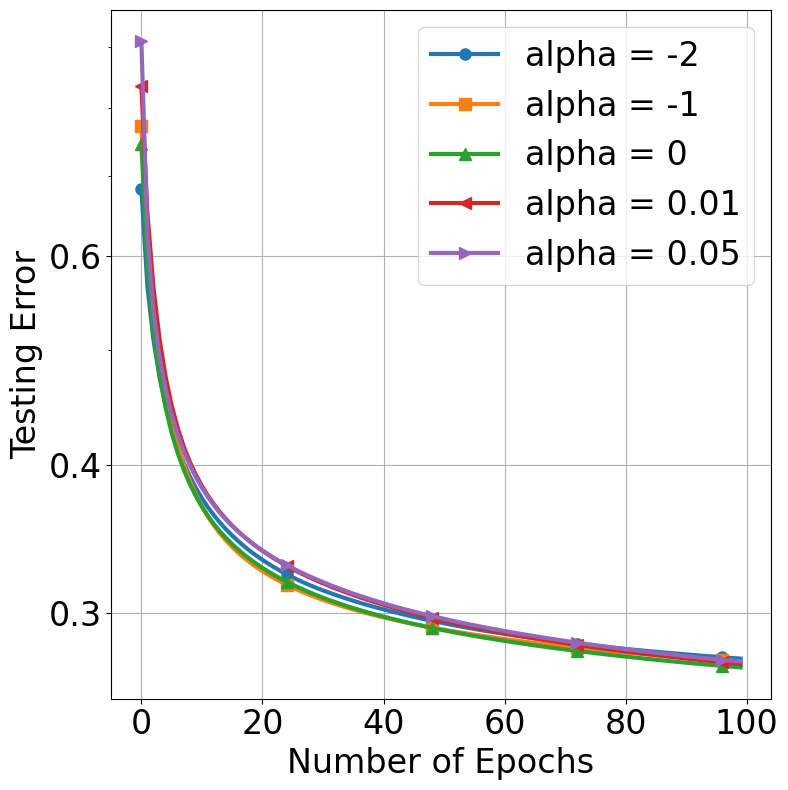

In [33]:
markers = {-2:'o', -1:'s', 0:'^', 0.01:'<', 0.05:'>', -10:'v'}
colors = {-1:'C1',-2:'C0',0:'C2', 0.05:'C4',0.01:'C3'}
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
# check_keys = [j for j in all_losses_alpha_more2.keys()]
j = 0
# markers = ['o', 's', '^', '<', '>', 'v', 'x', 'd', '*']
for key in check_keys:
    ax.plot(all_losses_alpha_test2_full[key][0:100], linewidth=3, 
            markersize=8, marker=markers[key], color=colors[key], markevery=24)
    j += 1
# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend([f'alpha = {j}' for j in check_keys], fontsize=24, loc='upper right')
ax.grid()
ax.set_xlabel("Number of Epochs", fontsize=24)
ax.set_ylabel("Testing Error", fontsize=24)
# ax.set_xticks([0, 1000, 2000, 3000, 4000])
# ax.set_xticklabels(["0", "1,000", "2,000", "3,000", "4,000"], fontsize=16)
# ax.set_yticks([0.03, 0.06, 0.1, 0.2])
# ax.set_yticklabels(['$3\\times 10^{-2}$', '$6\\times 10^{-2}$', '$10^{-1}$', '$2\\times 10^{-1}$'], fontsize=16)
ax.set_yticks([0.3, 0.4, 0.6])
ax.set_yticklabels([0.3, 0.4, 0.6], fontsize=24)
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels([0, 20, 40, 60, 80, 100], fontsize=24)
ax.set_title("")
fig.tight_layout()
fig.savefig('CH_plot_testing', dpi=600)